In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### **Check GPU and RAM availability**

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil

!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.9 GB  | Proc size: 138.9 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


### **Download Data**

In [0]:
'''
Link to file in google drive
'''

# https://drive.google.com/open?id=19l8nja9Sr7iGs4H3rpKpwCarLXH8h3mM

'''
File ID = 19l8nja9Sr7iGs4H3rpKpwCarLXH8h3mM
'''
# Download data from drive
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19l8nja9Sr7iGs4H3rpKpwCarLXH8h3mM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19l8nja9Sr7iGs4H3rpKpwCarLXH8h3mM" -O NNFL && rm -rf /tmp/cookies.txt

--2018-11-24 13:22:48--  https://docs.google.com/uc?export=download&confirm=M1so&id=19l8nja9Sr7iGs4H3rpKpwCarLXH8h3mM
Resolving docs.google.com (docs.google.com)... 74.125.126.100, 74.125.126.113, 74.125.126.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.126.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6n06hbb3cd6n4d79g6k3topb66bgee5v/1543060800000/04092678945227382373/*/19l8nja9Sr7iGs4H3rpKpwCarLXH8h3mM?e=download [following]
--2018-11-24 13:22:48--  https://doc-08-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6n06hbb3cd6n4d79g6k3topb66bgee5v/1543060800000/04092678945227382373/*/19l8nja9Sr7iGs4H3rpKpwCarLXH8h3mM?e=download
Resolving doc-08-ac-docs.googleusercontent.com (doc-08-ac-docs.googleusercontent.com)... 108.177.112.132, 2607:f8b0:4001:c12::84
Connecting to doc-08-ac-docs.googleusercontent.co

In [0]:
!ls

gdrive	NNFL_checkpoint_model_CNN.h5  NNFL.zip		  tokenizer.pickle
images	NNFL_Project_NEW_CNN_1.h5     Quest_Answers.json
NNFL	NNFL_Project_NEW_CNN.h5       sample_data


In [0]:
!mv NNFL NNFL.zip

In [0]:
!ls

gdrive			      NNFL_Project_NEW_CNN_1.h5  Quest_Answers.json
images			      NNFL_Project_NEW_CNN.h5	 sample_data
NNFL_checkpoint_model_CNN.h5  NNFL.zip			 tokenizer.pickle


### **Unzip the Data**

In [0]:
!unzip NNFL.zip

Archive:  NNFL.zip
replace images/CLEVR_new_000015.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace images/CLEVR_new_000027.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##Keras code

In [0]:
from __future__ import print_function
import json
import os.path
#import random as ra
import random
#import tensorflow as tf
from keras.backend import tf
import numpy as np
import keras
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Lambda, Embedding, LSTM, Conv2D, Activation
from keras.layers import MaxPooling2D, TimeDistributed, RepeatVector, Concatenate, Bidirectional, Conv1D, MaxPooling1D
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy import ndimage, misc
import pickle

Using TensorFlow backend.


In [0]:
#with open("Quest_Answers.json") as f:
#    data= json.load(f);
  
#data= data["quest_answers"]
#data

In [0]:
ls

gdrive/                       NNFL_Project_NEW_CNN_1.h5  Quest_Answers.json
images/                       NNFL_Project_NEW_CNN.h5    sample_data/
NNFL_checkpoint_model_CNN.h5  NNFL.zip                   tokenizer.pickle


In [0]:
def load_data(split, n, vocab_size, sequence_length, tokenizer=None):
  # Dataset paths
  #path = '../../Datasets/CLEVR_v1.0'
  #questions_path = path + '/questions/CLEVR_' + split + '_questions.json'
  #subset_questions_path = path + '/questions/CLEVR_' + split + '_questions_' + str(n) + '.json'
  #images_path = path + '/images/' + split + '/'

  x_text = []     # List of questions
  x_image = []    # List of images
  y = []          # List of answers
  num_labels = 0  # Current number of labels, used to create index mapping
  labels = {}     # Dictionary mapping of ints to labels
  images = {}     # Dictionary of images, to minimize number of imread ops
  #x_index = []

  # Attempt to load saved JSON subset of the questions
  print('Loading data...')

  """fos.path.exists(subset_questions_path):
    with open(subset_questions_path) as f:
      data = json.load(f)
  else:
    with open(questions_path) as f:
      data = json.load(f)

    data = data['questions'][0:n]

    with open(subset_questions_path, 'w') as outfile:
      json.dump(data, outfile)

    print('JSON subset saved to file...')"""
  
  with open("Quest_Answers.json") as f:
    data= json.load(f);
  
  data= data["quest_answers"][0:n]
  for i in data:
    i["Answer"] = str(i["Answer"])
  
  # Store image data and labels in dictionaries
  print('Storing image data...')

  for q in data[0:n]:
    # Create an index for each answer
    if not q["Answer"] in labels:
      labels[q['Answer']] = num_labels
      num_labels += 1

    # Create an index for each image
    if not q['Image'] in images:
      images[q['Image']] = misc.imread('images/' + q['Image'] + '.png', mode='RGB')

    x_text.append(q['Question'])
    x_image.append(images[q['Image']])
    #x_index.append((q['Index']))
    y.append(labels[q['Answer']])

  # Convert question corpus into sequential encoding for LSTM
  print('Processing text data...')

  if not tokenizer:
    tokenizer = Tokenizer(num_words=vocab_size)

  tokenizer.fit_on_texts(x_text)
  sequences = tokenizer.texts_to_sequences(x_text)
  x_text = sequence.pad_sequences(sequences, maxlen=sequence_length)

  # Convert x_image to np array
  x_image = np.array(x_image)

  # Convert labels to categorical labels
  y = keras.utils.to_categorical(y, num_labels)

  print('Text: ', x_text.shape)
  print('Image: ', x_image.shape)
  print('Labels: ', y.shape)

  return ([x_text, x_image], y), num_labels, tokenizer

In [0]:
#
# Environment Parameters
#
samples = 135000
epochs = 5
batch_size = 64
learning_rate = .00025
vocab_size = 1024
sequence_length = 48
img_rows, img_cols = 120, 160
image_input_shape = (img_rows, img_cols, 3)


In [0]:
#
# Load & Preprocess CLEVR
#
(x_train, y_train), num_labels, tokenizer = load_data('train', samples, vocab_size, sequence_length)

Loading data...
Storing image data...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


Processing text data...
Text:  (135000, 48)
Image:  (135000, 120, 160, 3)
Labels:  (135000, 26)


In [0]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [0]:
cp gdrive/My\ Drive/tokenizer.pickle tokenizer.pickle 

In [0]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [0]:
ls

gdrive/                       NNFL_Project_NEW_CNN_1.h5  Quest_Answers.json
images/                       NNFL_Project_NEW_CNN.h5    sample_data/
NNFL_checkpoint_model_CNN.h5  NNFL.zip                   tokenizer.pickle


In [0]:
print("x_train[0].shape = Text: {}".format(x_train[0].shape))
print("x_train[1].shape = Image: {}".format(x_train[1].shape))

x_train[0].shape = Text: (135000, 48)
x_train[1].shape = Image: (135000, 120, 160, 3)


## **New Start**

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input

In [0]:
def vgg(shape):
  image_in = Input(shape = shape) 
  model = VGG16(include_top = False, weights = 'imagenet')#, input_tensor = image_in)
  #print(model.summary())
  return model

In [0]:
def lstm(sequence_length, text_in):
  #text_in = Input(shape = (sequence_length,), name = 'text_in')
  text_in = text_in
  emb = Embedding(output_dim=256, input_dim=vocab_size, input_length=64)(text_in)
  emb = LSTM(256)(emb)
  emb = Dropout(0.5)(emb)
  return emb

In [0]:
# Load model

def conv(shape, image_in):
  #image_in = Input(shape = shape, name = 'image_in')
  image_in = image_in
  image_x = Conv2D(24, kernel_size=(3, 3), strides=2, activation='relu')(image_in)
  image_x = BatchNormalization()(image_x)
  image_x = Conv2D(48, kernel_size=(3, 3), strides=2, activation='relu')(image_x)
  image_x = BatchNormalization()(image_x)
  image_x = Conv2D(48, kernel_size=(3, 3), strides=2, activation='relu')(image_x)
  image_x = BatchNormalization()(image_x)
  image_x = Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu')(image_x)
  image_x = BatchNormalization()(image_x)
  image_x = Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu')(image_x)
  image_x = BatchNormalization()(image_x)
  image_x = keras.layers.Flatten()(image_x)
  #image_x = Conv2D(24, kernel_size=(3, 3), strides=2, activation='relu')(image_x)
  #image_x = BatchNormalization()(image_x)
  return image_x

In [0]:
def conv1D(sequence_length, text_in):
  text_in = text_in
  emb = Embedding(output_dim=256, input_dim=vocab_size, input_length=sequence_length)(text_in)
  emb = Conv1D(128, kernel_size = 3, strides = 2, activation = 'relu')(emb)
  emb = BatchNormalization()(emb)
  emb = keras.layers.Flatten()(emb)
  return emb

In [0]:
shape = (120, 160, 3)
text_in = Input(shape = (sequence_length,), name = 'text_in')
image_in = Input(shape = shape, name = 'image_in')

In [0]:
conv = conv(shape, image_in)

In [0]:
#vgg = vgg(shape)

In [0]:
lstm = conv1D(sequence_length, text_in)

In [0]:
x = keras.layers.concatenate([lstm, conv], axis=-1)

In [0]:
x = Dropout(0.5)(x)

In [0]:
x = Dense(256, activation = 'relu')(x)

In [0]:
x = Dropout(0.5)(x)

In [0]:
outputs = Dense(26, activation = 'softmax')(x)

In [0]:
model = Model(inputs = [text_in, image_in], outputs = outputs)

In [0]:
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
cp gdrive/My\ Drive/NNFL_Project_NEW_CNN.h5 NNFL_Project_NEW_CNN.h5

In [0]:
model2 = keras.models.load_model('NNFL_Project_NEW_CNN.h5')

In [0]:
ls

gdrive/                       NNFL_Project_NEW_CNN_1.h5  Quest_Answers.json
images/                       NNFL_Project_NEW_CNN.h5    sample_data/
NNFL_checkpoint_model_CNN.h5  NNFL.zip                   tokenizer.pickle


In [0]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
checkpoint = ModelCheckpoint('NNFL_checkpoint_model_CNN.h5', monitor = 'val_loss', verbose = 1, save_best_only = True, save_weights_only = False, mode = 'auto', period = 1)

In [0]:
history = model2.fit(x_train, y_train, batch_size=32, epochs=10, validation_split= 0.1, shuffle=True, verbose=1, callbacks = [checkpoint])

Train on 121500 samples, validate on 13500 samples
Epoch 1/10
121500/121500 [==============================] - 126s 1ms/step - loss: 1.0063 - acc: 0.4869 - val_loss: 1.0253 - val_acc: 0.4619

Epoch 00001: val_loss improved from inf to 1.02529, saving model to NNFL_checkpoint_model_CNN.h5
Epoch 2/10
121500/121500 [==============================] - 133s 1ms/step - loss: 1.0046 - acc: 0.4883 - val_loss: 1.0294 - val_acc: 0.4575

Epoch 00002: val_loss did not improve from 1.02529
Epoch 3/10
121500/121500 [==============================] - 125s 1ms/step - loss: 1.0034 - acc: 0.4895 - val_loss: 1.0286 - val_acc: 0.4521

Epoch 00003: val_loss did not improve from 1.02529
Epoch 4/10
121500/121500 [==============================] - 133s 1ms/step - loss: 0.9991 - acc: 0.4917 - val_loss: 1.0226 - val_acc: 0.4586

Epoch 00004: val_loss improved from 1.02529 to 1.02261, saving model to NNFL_checkpoint_model_CNN.h5
Epoch 5/10
121500/121500 [==============================] - 132s 1ms/step - loss: 0.9

In [0]:
model.save('NNFL_Project_NEW_CNN_1.h5')

In [0]:
ls

gdrive/    NNFL_checkpoint_model_CNN.h5  NNFL.zip            tokenizer.pickle
images/    NNFL_Project_NEW_CNN_1.h5     Quest_Answers.json
model.png  NNFL_Project_NEW_CNN.h5       sample_data/


In [0]:
model2 = keras.models.load_model('NNFL_Project_NEW_CNN_1.h5')

In [0]:
model3 = keras.models.load_model('NNFL_checkpoint_model_CNN.h5')

In [0]:
cp NNFL_Project_NEW_CNN_1.h5 gdrive/My\ Drive/NNFL_Project_NEW_CNN_1.h5

In [0]:
cp NNFL_checkpoint_model_CNN.h5 gdrive/My\ Drive/NNFL_checkpoint_model_CNN.h5

In [0]:
#cp tokenizer.pickle gdrive/My\ Drive/tokenizer.pickle

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


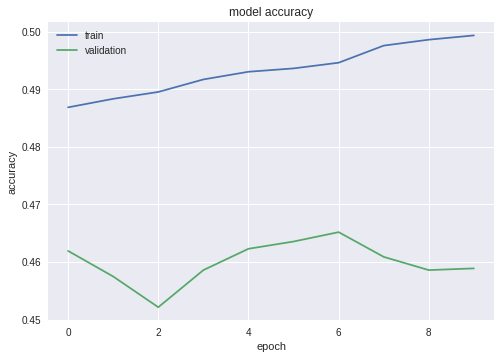

In [0]:
import matplotlib.pyplot as plt
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

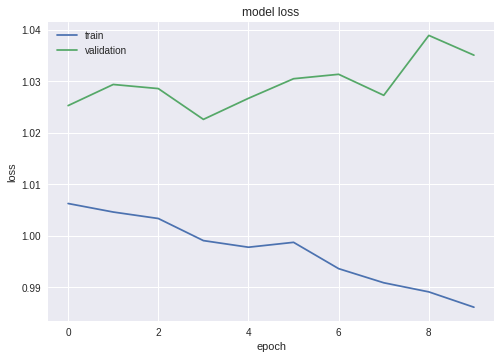

In [0]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
model.summary()

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
cp model.png gdrive/My\ Drive/model.png

In [0]:
!pip install pydot

In [0]:
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot

In [0]:
!pip install -q pydot